In [2]:
import pandas as pd
from gensim.models import LdaMulticore
from helper_data import *
from helper_preprocess import *


%load_ext autoreload
%autoreload 2

## Load the data

In [3]:
# Load data
walks_folder = 'data/P3'
walk_path = 'all_p3'
#data = load_all_walks_comments(walks_folder, True)
data = load_all_walks_tags(walks_folder, True)

In [24]:
# Drop the videos where nan occurs
data = data.dropna(subset='keywords')
tags = data['keywords'].tolist()
walks_id = data['walk'].tolist()

In [9]:
len(tags)

491

## Preprocessing

In [10]:
# Preprocess the data
tags_prep = [preprocess(t, tag=True) for t in tags]

In [14]:
# Filter out words that appear in more than 30% of the videos and words that
# appear less than 3 times
min_words = 3
max_freq = 0.3

dictionary, corpus = create_corpus(tags_prep, min_words, max_freq)

In [15]:
len(corpus)

491

## LDA

In [16]:
# LDA parameters
workers = 3
passes = 1000
random_state = 123
num_topics = 12
alpha = 0.05 # < 1 gives sparse topics distributions
eta = 0.05 # < 1 gives sparse words distribution inside each topic

lda_model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=workers, passes=passes, random_state=random_state, alpha=alpha, eta=eta)

In [17]:
lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

[(0,
  [('cover', 0.052822966),
   ('official', 0.05234242),
   ('new', 0.04690687),
   ('pump', 0.03907302),
   ('exposed', 0.03907293),
   ('water', 0.038978178),
   ('cave', 0.036781315),
   ('cliff', 0.036781315),
   ('acoustic', 0.034382347),
   ('tiktok', 0.03428929)]),
 (1,
  [('make', 0.10497042),
   ('hack', 0.05668948),
   ('cooking', 0.053971186),
   ('britney', 0.052525472),
   ('spear', 0.052525472),
   ('food', 0.04824831),
   ('home', 0.04482339),
   ('recipe', 0.040202744),
   ('easy', 0.03712178),
   ('idea', 0.036898907)]),
 (2,
  [('idea', 0.09421545),
   ('cement', 0.07142932),
   ('video', 0.061155934),
   ('official', 0.05502963),
   ('table', 0.051621787),
   ('music', 0.051285602),
   ('make', 0.043451615),
   ('gas', 0.028986081),
   ('remastered', 0.028986065),
   ('creative', 0.027692785)]),
 (3,
  [('ed', 0.09383112),
   ('sheeran', 0.07768113),
   ('houston', 0.04861124),
   ('love', 0.04461002),
   ('whitney', 0.04215125),
   ('mod', 0.038707845),
   ('wug

Tests made :
passes=10 for below
- alpha=0.5, eta=1, num_topics=10 :
    - Individual topics easily interpretable, but some are a bit mixed -> decrease alpha and maybe eta too, to get more polarized topics in each video and more specific vocabulary in each topic
    - Multiple topics about the same subject : especially music -> reduce number of topics
- alpha=0.2, eta=1, num_topics=10 :
    - More polarized topics as wanted
    - Still some mixed topics
    - Still multiple topics about the same subjects (especially music again)
- alpha=0.2, eta=1, num_topics=7 :
    - Fewer similar topics, but kind of more mixed words in each topic
- alpha=0.2, eta=0.8, num_topics=7 :
    - Still approx. 2 topics on music -> reduce num_topics
- alpha=0.2, eta=0.8, num_topics=6 :
    - More or less distinct topics
    - First 4 are easily interpretable but last 2 are more mixed (music-minecraft)
- alpha=0.2, eta=0.8, num_topics=5 :
    - Even more mixed up topics -> need more than 5 topics to fit well


passes=50 for below (training time is still very short)
- alpha=0.1, eta=0.7, num_topics=7 :
    - Still a bit mixed up topics in the last 2 -> might actually need to increase num_topics but set sharper alpha and eta
- alpha=0.1, eta=0.1, num_topics=8 :
    - Again the first few topics are very good but the last ones are more mixed up

Observation : might want to remove the word "official", appears often in the topics (e.g. for music, etc) but not really informative about the subject

passes=100 for below (training time is still very short)
- alpha=0.1, eta=0.1, num_topics=8 :
    - Similar to passes=50
- alpha=50/num_topics (typical value used in practice), eta=0.1, num_topics=8 :
    - Quite good topics but somewhat mixed -> try to lower the 50
- alpha=25/num_topics, eta=0.1, num_topics=8 :
    - Quite good topics
- alpha=25/num_topics, eta=0.1, num_topics=7 :
    - Quite good topics but a bit more mixed -> keep num_topics=8
- alpha=1, eta=0.1, num_topics=8 :
    - Quite good topics but got two music topics
- alpha=25/num_topics, eta=0.01, num_topics=8 :
    - Topics very similar to previous setup
    - Again 2 topics on music
- alpha=10/num_topics, eta=0.01, num_topics=8 :
    - Again very similar to previous setup
    - And again 2 topics on music
- alpha=0.99, eta=0.1, num_topics=15 :
    - Not so bad : many similar topics but more interpretable (less mixed)


In the end -> have to tune with final data

## Clustering the videos

In [18]:
# Build the "embeddings" for each document using its topics distribution
embeddings = np.zeros((len(corpus), num_topics))
for i, doc_bow in enumerate(corpus):
    topics_distr = lda_model.get_document_topics(doc_bow)
    embedding = [0.0] * num_topics

    for id, p in topics_distr:
        embedding[id] = p

    embeddings[i, :] = embedding

In [19]:
from sklearn.manifold import TSNE

# Init pca is more stable,
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=random_state)
corpus_emb = tsne.fit_transform(embeddings)

/home/cpittet/anaconda3/envs/shs/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


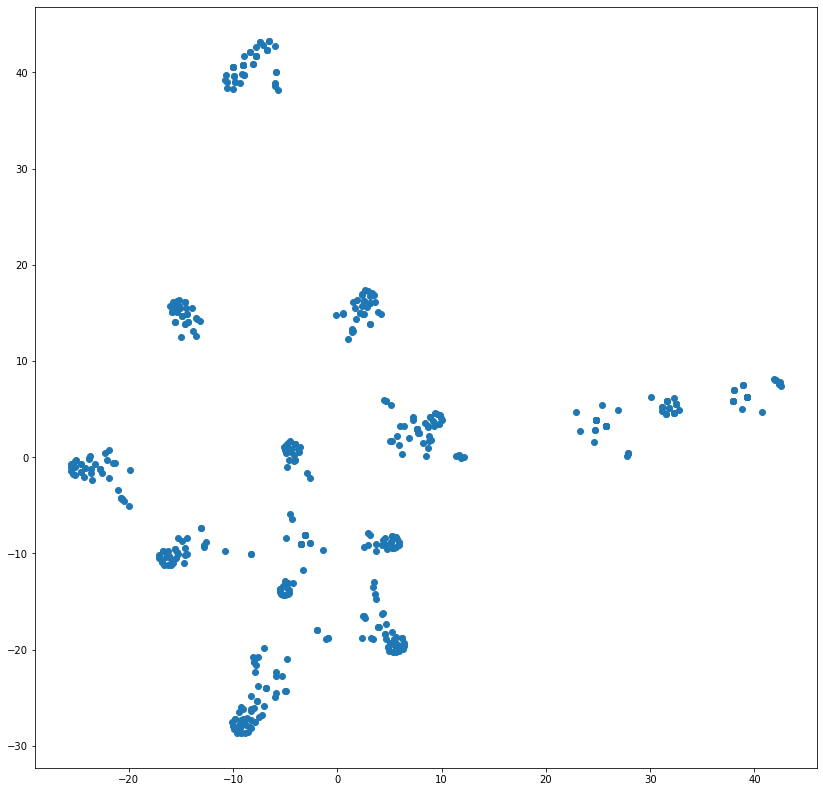

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,14)

plt.scatter(corpus_emb[:, 0], corpus_emb[:, 1])
plt.show()

In [32]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

from matplotlib.colors import rgb2hex
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

Loading BokehJS ...

In [33]:
xs, ys = corpus_emb[:, 0], corpus_emb[:, 1]
best_topic_ids = [np.argmax(row) for row in embeddings.tolist()]

# We will need to separate runs, here we have all runs of P3
colors = [val2rgb(i) for i in range(len(xs))]

In [46]:
# Use pandas and plotly instead
df = pd.DataFrame({'x': corpus_emb[:, 0], 'y': corpus_emb[:, 1], 'best_topic_id': best_topic_ids, 'walk_id': [str(i) for i in walks_id], 'color': colors})

In [48]:
import plotly.express as px

fig = px.scatter(df, x='x', y='y', color='walk_id', hover_data=['best_topic_id'], width=800, height=800)
fig.show()